# FER2013 Quickstart (Train & Evaluate)

This notebook guides you through downloading FER2013 with KaggleHub, preparing the dataset, training a ResNet-18 classifier on grayscale 48×48 images, and evaluating with confusion matrix and per-class metrics.

## 0. Environment Setup
Create a virtual environment (optional) and install dependencies. If using Colab or a managed environment, you can skip the venv step.

In [ ]:
!python -m venv .venv
!source 
!pip -q install -r requirements.txt -r requirements-dev.txt

## 1. Download and Prepare FER2013 (ImageFolder)
This will create `data/train`, `data/val`, and `data/test` with a 75/25 train/val split and the official test set.

In [30]:
!python ../scripts/prepare_fer2013.py --out-dir /projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data --val-ratio 0.25

The directory '/projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data' exists. 
Splitting train into 0.25/0.75 for train/validation ...
998 images moving into /projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data/val/angry ...
109 images moving into /projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data/val/disgusted ...
1024 images moving into /projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data/val/fearful ...
1803 images moving into /projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data/val/happy ...
1207 images moving into /projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data/val/sad ...
792 images moving into /projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data/val/surprised ...


Classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Class: angry (showing 3)


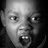

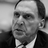

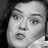

Class: disgusted (showing 3)


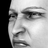

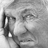

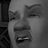

Class: fearful (showing 3)


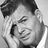

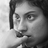

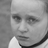

Class: happy (showing 3)


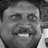

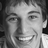

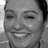

Class: neutral (showing 3)


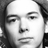

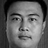

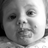

Class: sad (showing 3)


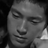

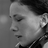

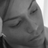

Class: surprised (showing 3)


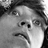

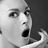

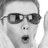

In [31]:
# Preview a few samples per class from the training split
import os, random
from IPython.display import display
from PIL import Image
root = '../data/train'
classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
print('Classes:', classes)
samples_per_class = 3
for cls in classes:
    cls_dir = os.path.join(root, cls)
    imgs = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    random.shuffle(imgs)
    print(f'Class: {cls} (showing {min(samples_per_class, len(imgs))})')
    for path in imgs[:samples_per_class]:
        display(Image.open(path))


## 2. Train (ResNet-18, grayscale 1-ch, with imbalance handling)
- Uses weighted sampling and class-weighted CE
- AMP enabled by default (GPU recommended)
- Adjust `--epochs` and `--batch-size` to your hardware

In [39]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 70.2 MB/s  0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]━━━ 3/4 [seaborn]


In [40]:
import torch
batch = 256 if torch.cuda.is_available() else 64
epochs = 60
!python ../scripts/train.py \
--data-dir ../data \
--out-dir ../runs/9/1 \
--epochs {epochs} \
--batch-size {batch} \
--img-size 48 \
--arch resnet18 \
--weighted-sampler \
--class-weighted-ce \
--label-smoothing 0.1

/work/projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/src/resnet/train.py:225: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=cfg.amp)
Epoch 1/60 | train 1.1057/19.73 | val 2.0472/13.57 | best 13.57                 
              precision    recall  f1-score   support

           0     0.1955    0.0260    0.0459       999
           1     0.0220    0.9541    0.0429       109
           2     0.2273    0.1074    0.1459      1024
           3     0.7540    0.0527    0.0985      1803
           4     0.3657    0.0516    0.0904      1241
           5     0.2922    0.0373    0.0661      1207
           6     0.3883    0.6692    0.4914       792

    accuracy                         0.1357      7175
   macro avg     0.3207    0.2712    0.1402      7175
weighted avg     0.4047    0.1357    0.1336      7175

Epoch 2/60 | train 0.8529/35.65 |

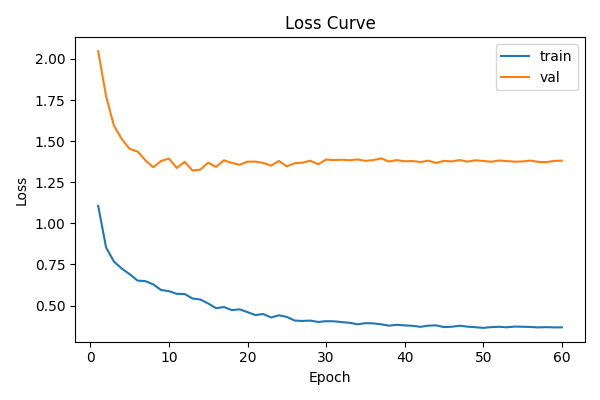

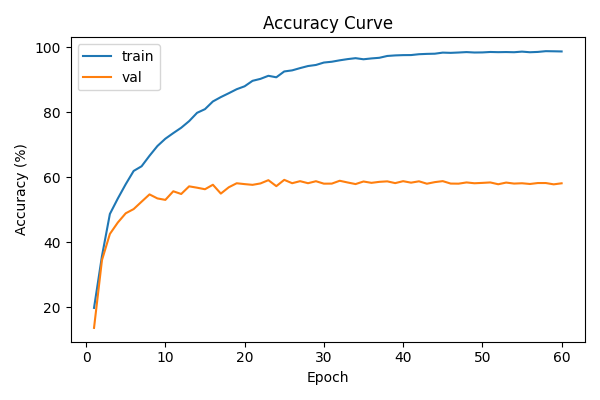

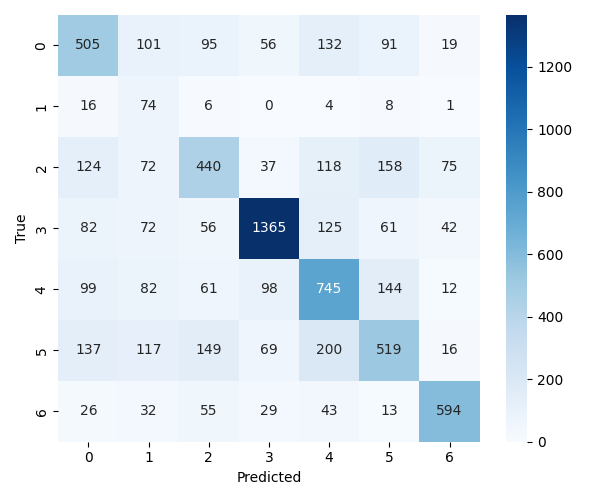

In [47]:
# Display training curves from the run directory
from IPython.display import Image, display
import os
run_dir = '../runs/9/1'
for fname in ['loss_curve.png', 'accuracy_curve.png', 'confusion_matrix_best.png']:
    path = os.path.join(run_dir, fname)
    if os.path.exists(path):
        display(Image(filename=path))

## 3. Evaluate on Validation and Test Splits
Saves confusion matrix and per-class precision/recall charts, plus a CSV of per-class metrics.

In [57]:
!python ../scripts/eval_classification.py --data-dir ../data/val --weights ../runs/9/1/best.pt --arch resnet18 --img-size 48
!python ../scripts/eval_classification.py --data-dir ../data/test --weights ../runs/9/1/best.pt --arch resnet18 --img-size 48

Eval: 100%|█████████████████████████████████████| 29/29 [00:32<00:00,  1.13s/it]
              precision    recall  f1-score   support

       angry     0.5122    0.5055    0.5088       999
     disgust     0.1348    0.6789    0.2249       109
        fear     0.5111    0.4287    0.4663      1024
       happy     0.8243    0.7571    0.7892      1803
     neutral     0.5439    0.5995    0.5703      1241
         sad     0.5191    0.4283    0.4694      1207
   surprised     0.7806    0.7500    0.7650       792

    accuracy                         0.5907      7175
   macro avg     0.5465    0.5926    0.5420      7175
weighted avg     0.6210    0.5907    0.6012      7175

Eval: 100%|█████████████████████████████████████| 29/29 [00:13<00:00,  2.09it/s]
              precision    recall  f1-score   support

       angry     0.4859    0.5198    0.5023       960
     disgust     0.1550    0.7207    0.2552       111
        fear     0.5261    0.4238    0.4694      1024
       happy     0.8290 

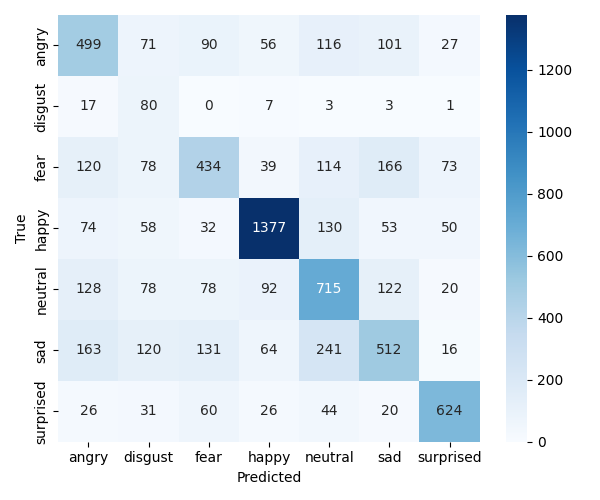

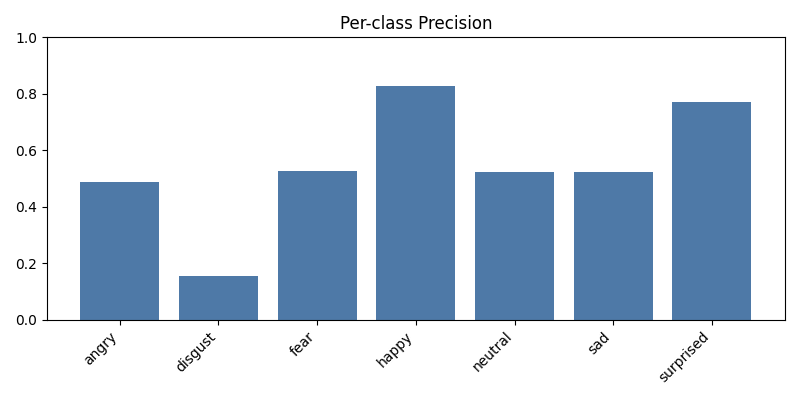

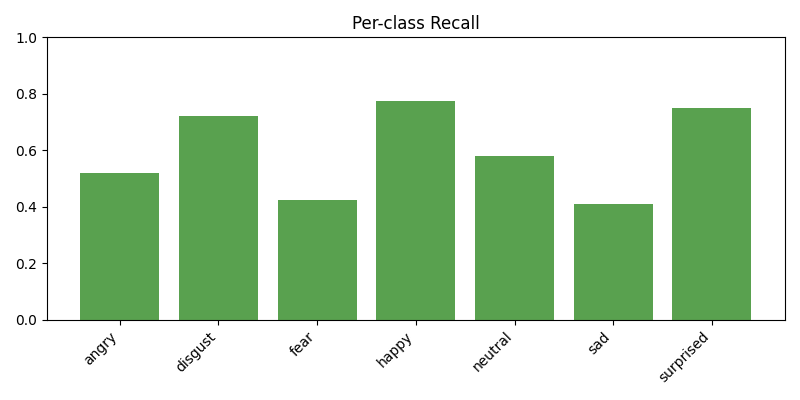

In [58]:
# Display evaluation artifacts inline if present
from IPython.display import Image, display
import os
for fname in ['confusion_matrix.png', 'precision_per_class.png', 'recall_per_class.png']:
    if os.path.exists(fname):
        display(Image(filename=fname))

Outputs in the working directory: 
- `confusion_matrix.png`
- `precision_per_class.png`
- `recall_per_class.png`
- `metrics_per_class.csv`

### Distributed Training (DDP)
Run from a terminal (notebooks are not ideal for multi-process). Example:

`````
CUDA_VISIBLE_DEVICES=0,1 torchrun --standalone --nproc_per_node=2 scripts/train.py \
  --data-dir data --out-dir runs/ddp_fer --epochs 10 --batch-size 256 --img-size 48 --arch resnet18 --weighted-sampler --class-weighted-ce
`````
Artifacts will be saved under `runs/ddp_fer/` on rank 0.


In [56]:
!CUDA_VISIBLE_DEVICES=0,1 torchrun --standalone --nproc_per_node=2 ../scripts/train.py \
    --data-dir ../data \
    --out-dir ../runs/9/1ddp \
    --epochs 60 \
    --batch-size 2048 \
    --img-size 48 \
    --arch resnet18 \
    --weighted-sampler \
    --class-weighted-ce \
    --label-smoothing 0.1 \

W0901 21:09:40.197000 1848418 torch/distributed/run.py:774] 
W0901 21:09:40.197000 1848418 torch/distributed/run.py:774] *****************************************
W0901 21:09:40.197000 1848418 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0901 21:09:40.197000 1848418 torch/distributed/run.py:774] *****************************************
usage: train.py [-h] --data-dir DATA_DIR [--out-dir OUT_DIR] [--arch ARCH]
                [--img-size IMG_SIZE] [--batch-size BATCH_SIZE]
                [--epochs EPOCHS] [--lr LR] [--weight-decay WEIGHT_DECAY]
                [--no-pretrained] [--weighted-sampler]
                [--num-workers NUM_WORKERS] [--no-amp] [--seed SEED]
                [--distributed] [--dist-backend DIST_BACKEND]
                [--label-smoothing LABEL_SMOOTHING] [--class-weigh

Artifacts are saved under `runs/fer18/`:
- `best.pt`, `last.pt`
- `history.json`, `history.csv`
- `loss_curve.png`, `accuracy_curve.png`
- `confusion_matrix_epoch*.png`, `confusion_matrix_best.png`

## 4. Notes
- Adjust batch size if you run on CPU.
- Training artifacts: check `runs/fer18/`.
- For DDP, prefer a terminal and ensure CUDA is available.
